In [1]:
import os

import numpy as np

import torch
import torchvision

from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint

from models.conv3d_encdec.model import PlaceholderModel
from models.conv3d_encdec.loader import SingleChannelDataset

from pathlib import Path
from argparse import Namespace

import tqdm

import pandas as pd

import plotly.express as px
import plotly.graph_objects as go

import cv2

In [2]:
inputs_outputs_save_path = '/scratch/ns4486/capstone/results_num_10.npy'

run_through_model = False
generate_input_images = True
input_images_path = '/scratch/prs392/capstone/simulations/original_35th_frames'
generate_output_images = True
output_images_path = '/scratch/prs392/capstone/simulations/predict_35th_frames_model_num_10/'
generate_videos = True
all_expected_predicted_video_path = '/scratch/prs392/capstone/simulations/videos/all_expected_predicted.avi'
choppy_expected_predicted_video_path = '/scratch/prs392/capstone/simulations/videos/choppy_expected_predicted.avi'


In [3]:
if run_through_model:

    checkpoint_dir = "/scratch/ns4486/capstone/checkpoints/conv_ae/arch_2/AE_batch1/NUM-10/checkpoints/last.ckpt"
    data_path = '/scratch/ns4486/numerical-relativity-interpolation/Proca_fiducial_scaled_cropped.hdf5'

    model = PlaceholderModel.load_from_checkpoint(checkpoint_dir, hparams = {}, data_path=data_path)

    model = model.eval()

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    model = model.to(device)

    dataset = SingleChannelDataset(data_path)

    outputs = None
    inputs = None

    with torch.no_grad():
        for i in tqdm.tqdm(range(len(dataset))):
            x1 = dataset[i][0].unsqueeze(0)
            x2 = dataset[i][1].unsqueeze(0)
            x1 = x1.to(device)
            x2 = x2.to(device)
            z = model(x1, x2)
            y_hat = model.decoder(z)

            if inputs is None:
                inputs = torch.cat((dataset[i][0], dataset[i][1]))
                inputs = inputs.unsqueeze(0)
            else:
                t = torch.cat((dataset[i][0], dataset[i][1])).unsqueeze(0)
                inputs = torch.cat((inputs, t))

            if outputs is None:
                outputs = y_hat.cpu().squeeze(0).detach().numpy()
            else:
                outputs = np.concatenate((outputs, y_hat.cpu().squeeze(0).detach().numpy()), axis=0)

    outputs = outputs.reshape((407, 1, 72, 72, 72))
    inputs = np.array(inputs)

    with open(inputs_outputs_save_path, 'wb') as f:
        np.save(f, inputs)
        np.save(f, outputs)

In [4]:
if generate_input_images or generate_output_images:

    with open(inputs_outputs_save_path, 'rb') as f:
        inputs = np.load(f)
        outputs = np.load(f)

    new_input = inputs[:, 0, 35, :, :]
    new_output = outputs[:, 0, 35, :, :]

    cats = pd.qcut(new_input.flatten(), q=30)

    color_interval_values = []
    color = 1

    for interval in list(cats.categories):
        color_interval_values.append([interval.left, interval.right, color])
        color += 1

    color_intervals_df = pd.DataFrame(color_interval_values, columns=['left', 'right', 'color'])
    color_intervals_df

    def estimate_color(x):
        for index, row in color_intervals_df.iterrows():
            if x > row.left and x <= row.right:
                return row.color
        if x <= color_intervals_df.iloc[0]['left']:
            return 1
        else:
            return 30


In [5]:
import plotly.io as pio
print(pio.orca.config.plotlyjs)

/ext3/miniconda3/lib/python3.8/site-packages/plotly/package_data/plotly.min.js


In [7]:
import matplotlib.pyplot as plt

  0%|          | 0/407 [00:06<?, ?it/s]


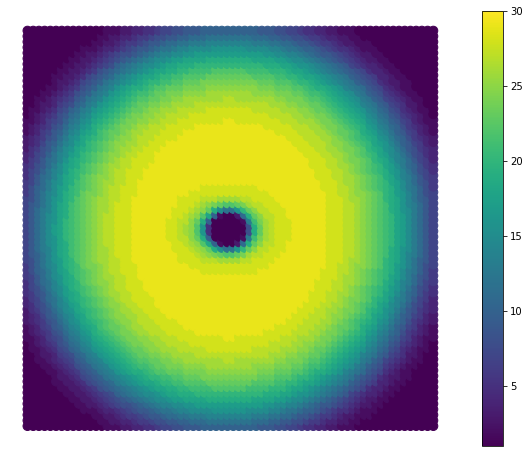

In [22]:
if generate_input_images:

    for index in tqdm.tqdm(range(new_input.shape[0])):
        location_value = []
        frame = 0

        for i in range(new_input[index].shape[0]):
            for j in range(new_input[index].shape[1]):
                location_value.append([i, j, new_input[index, i, j]])

        df = pd.DataFrame(data = location_value, columns=['x', 'y', 'value'])

        df['color'] = df['value'].apply(estimate_color)
        
        plt.figure(figsize=(10, 8))
        
        plt.scatter(df['x'], df['y'], c=df['color'], vmin=1, vmax=30, s=80)
        
        plt.colorbar()
        plt.axis('off')
        
        plt.plot()

        plt.savefig(os.path.join(input_images_path, f'{index}.png'), dpi = 50)
        

In [ ]:
if generate_output_images:

    for index in tqdm.tqdm(range(new_output.shape[0])):
        location_value = []
        frame = 0

        for i in range(new_output[index].shape[0]):
            for j in range(new_output[index].shape[1]):
                location_value.append([i, j, new_output[index, i, j]])

        df = pd.DataFrame(data = location_value, columns=['x', 'y', 'value'])

        df['color'] = df['value'].apply(estimate_color)

#         fig = px.scatter(df, x='x', y='y', color='color', range_color = [1, 30], color_continuous_scale='Viridis', width=800, height=800)

#         fig.update_traces(marker=dict(size=12), selector=dict(mode='markers'))

#         fig.write_image(os.path.join(output_images_path, f'{index}.png'), width=800, height=800)
        
        plt.figure(figsize=(10, 8))
        
        plt.scatter(df['x'], df['y'], c=df['color'], vmin=1, vmax=30, s=80)
        
        plt.colorbar()
        plt.axis('off')
        
        plt.plot()

        plt.savefig(os.path.join(output_images_path, f'{index}.png'), dpi = 50)
        

  1%|          | 4/407 [00:15<26:39,  3.97s/it]

In [ ]:
if generate_videos:

    original_images = [f'{i}.png' for i in range(407)]
    original_images = original_images[1:]

    predicted_images = [f'{i}.png' for i in range(407)]
    predicted_images = predicted_images[:-1]


    frame = cv2.imread(os.path.join(input_images_path, original_images[0]))
    height, width, layers = frame.shape

    video = cv2.VideoWriter(all_expected_predicted_video_path, 0, 10, (width*2,height))

    for i in range(len(original_images)):
        # change on every other image
        left_img = cv2.imread(os.path.join(input_images_path, original_images[i]))

        right_img = cv2.imread(os.path.join(output_images_path, predicted_images[i]))

        im_h = cv2.hconcat([left_img, right_img])

        video.write(im_h)

    cv2.destroyAllWindows()
    video.release()


    original_images = [f'{i}.png' for i in range(407)]
    predicted_images = [f'{i}.png' for i in range(407)]

    frame = cv2.imread(os.path.join(input_images_path, original_images[0]))
    height, width, layers = frame.shape

    video = cv2.VideoWriter(choppy_expected_predicted_video_path, 0, 10, (width*3,height))

    for i in range(len(original_images)):
        # change on every other image
        if i % 2 == 0:
            left_img = cv2.imread(os.path.join(input_images_path, original_images[i]))

            right_img = left_img
        else:
            right_img = cv2.imread(os.path.join(output_images_path, predicted_images[i - 1]))

        mid_img = cv2.imread(os.path.join(input_images_path, original_images[i]))

        im_h = cv2.hconcat([left_img, mid_img, right_img])

        video.write(im_h)

    cv2.destroyAllWindows()
    video.release()